# CIVL 580: Geotechnical Earthquake Engineering

***Sample Solution for Assignment #2***

## 1D Response of Uniform Damped Soil over Elastic Rock

## **Question**
Consider the dynamic response of a uniform, damped soil layer over elastic rock to a vertically propagating harmonic shear wave. Prepare a solution to this problem following the procedures outlined in section 7.2.1.1 of *Kramer (1996)*. Your solution must be prepared in **Python**. The input parameters should be: 
* the shear wave velocity ($Vs_{soil}$), fraction of critical damping ($\xi$) and density for the soil ($\gamma_{soil}$);
* the shear wave velocity ($Vs_{rock}$), fraction of critical damping and density for the bedrock ($\gamma_{rock}$)
* the thickness of the soil layer ($H$)
* the period ($T$) or frequency ($\omega$), of the harmonic wave that would be recorded at the bedrock outcrop

Your worksheet must include plots of acceleration versus time, acceleration response spectra (for $5\%$
damping), Fourier amplitude versus period, and Fourier amplification ratio (soil surface relative to out-
crop) versus period. Show results for the soil surface and the outcrop on the same plots. Check your work by seeing if you get similar transfer functions to those shown in Figure 7.5 (set the bedrock shear wave velocity very large) and Figure 7.8 (but note that there is a mistake in this plot, which is clear upon further examination of equation 7.27). 
Submit a copy of your worksheet for the following baseline case. A 15-m-thick soil layer that has a shear wave velocity of $100\ m/s$, a damping ratio of $5\ \%$, and a density of $1.8\ t/m^3$. The bedrock has a shear wave velocity of $800\ m/s$, a damping ratio of $0.1\ \%$, and a density of $2.2\ t/m^3$. The bedrock outcrop acceleration is a harmonic wave of amplitude $1\ m/s^2$ and period $0.5\ s$.



> (a) Discuss the sensitivity of the peak soil surface acceleration to the damping ratio for the soil layer ($\xi$), given that the period of the outcrop harmonic wave could be anything between $0.1$ and $5$ $s$. To illustrate the sensitivity, prepare a plot showing the peak soil surface acceleration versus soil damping ratio (for values of $0$ to $20\%$) for one specified harmonic period. Then show this plot for the harmonic periods that produce the least and greatest sensitivity. Explain your findings.

> (b) Discuss the sensitivity of the peak soil surface acceleration to the shear wave velocity of the soil layer, again given that the period of the outcrop harmonic wave could be anything between $0.1$ and $5$ $s$. In this case, suppose that the true shear wave velocity might be anything between $75$ and $125$ $m/s$. Referring only to the transfer function (you don't need to do any specific analyses), estimate the harmonic periods at which you believe the soil surface acceleration would have the least and greatest sensitivity to variations in the soil shear wave velocity. Explain your answer.





## **Solution**
Soil layer has a defined shear wave velocity, damping ratio, and thickness. Bedrock has a defined shear wave velocity and damping ratio. The outcrop motion is a single harmonic with peak acceleration of $1\ m/s^2$. This solution is prepared based on **Python** and used the built-in functions **fft** and **ifft** to compute the Fourier and Inverse Fourier transforms. Also, the package [eqsig](https://eqsig.readthedocs.io/en/latest/) is used to calculate the response spectra. 


### 1 Importing packages

In [1]:
# Importing general packages
import numpy as np
import pandas as pd
import math
import cmath
import matplotlib as mpl 
import matplotlib.pyplot as plt
%matplotlib inline

# Importing modules for signal processing
from scipy.fftpack import fft, ifft
from scipy import signal

### 2 Input parameters

In [2]:
# Soil parameters
Vs_soil       = 100         # [m/s] soil shear wave velocity
damp_soil     = 0.05        # [-]
density_soil  = 1800        # [kg/m3]
H             = 15          # [m]

# Bedrock parameters
Vs_rock       = 800         # [m/s] rock shear wave velocity
damp_rock     = 0.001       # [-]
density_rock  = 2200        # [kg/m3]

# Outcrop motion
Tw            = 0.50        # [sec] period of harmonic wave between 0.1 and 5.0 sec
Ncyc          = 12          # [-] number of cycles
Np            = 2**10       # [-] number of points for outcrop motion
num           = int(Np/2)   # [-] integer number (Np/2)
amax_outcrop  = 1           # [m/s2] peak acceleration of input motion

### 3 Input motion and transfer function

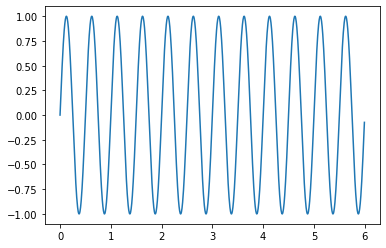

In [3]:
# Defining input motion and transfer function
dt        = Tw*Ncyc/Np                            # increment of time (sampling interval)
k         = np.linspace(0,Np-1,Np)                # creating array of points
t_k       = k*dt                                  # domain of time: t_k, array of 'Np' points
a_outcrop = amax_outcrop*np.sin(2*math.pi/Tw*t_k) # [m/s2]

# Plotting input motion at the rock level
plt.plot(t_k,a_outcrop)
plt.show()

In [4]:
# Complex stiffness and shear wave velocities
G_soil_complex  = density_soil * (Vs_soil**2) * (1+2j*damp_soil)  # [Pa]
G_rock_complex  = density_rock * (Vs_rock**2) * (1+2j*damp_rock)  # [Pa]
Vs_soil_complex = cmath.sqrt(G_soil_complex/density_soil)         # [m/s]
Vs_rock_complex = cmath.sqrt(G_rock_complex/density_rock)         # [m/s]

In [ ]:
# Transfer function from outcrop to soil surface
# Ref: Kramer, 1996 (eq.7.25)
dw     = 2*math.pi/(Np*dt)                                                             # increment of frequencies
w_k    = k*dw                                                                          # domain of frequencies: w_k, array of 'Np' points
w_k[0] = 2*math.pi/10 
T_k    = 2*math.pi/w_k                                                                 # domain of periods: T_k, array of 'Np' points
alpha  = (density_soil*Vs_soil_complex) / (density_rock*Vs_rock_complex)               # complex impedance ratio
ks     = w_k/Vs_soil_complex                                                           # complex wave number
TF     = 2/((1+alpha)*np.exp(complex(0,1)*ks*H)+(1-alpha)*np.exp(complex(0,-1)*ks*H))  # transfer function

### 4 Fast Fourier Transform

**Notes:** \\
Link 1: https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.fft.html#scipy.fftpack.fft \\
Link 2: https://numpy.org/doc/stable/reference/routines.fft.html#background-information \\
Because ***a_outcrop*** is a real input, the FFT is symmetrical in the real part and anti-symmetric in the imaginary part

In [6]:
# Fast Fourier Transform calculations
FFT_a_outcrop = fft(a_outcrop)            # np.array of complex numbers
FFT_a_outcrop = FFT_a_outcrop[0:num]      # considering only zero and positive-frequency values
FFT_a_soil    = TF[0:num]*FFT_a_outcrop   # np.array of complex numbers
a_soil        = ifft(FFT_a_soil)          # np.array of complex numbers

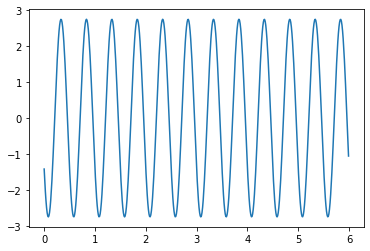

In [7]:
# Plotting accelaration at the soil surface
plt.plot(t_k[0:num]*2,a_soil.real)
plt.show()

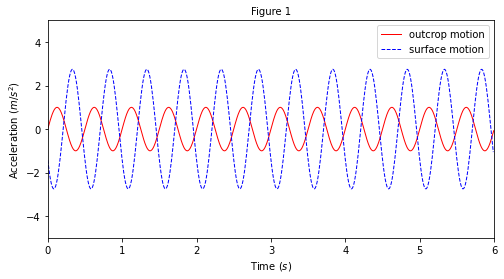

In [8]:
#Acceleration time histories
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
ax.plot(t_k         ,a_outcrop  , label='outcrop motion', color='r',ls='-' , lw=1)
ax.plot(t_k[0:num]*2,a_soil.real, label='surface motion', color='b',ls='--', lw=1)
ax.set_title('Figure 1', fontsize=10)
ax.set_xlabel('Time $(s)$')
ax.set_ylabel('Acceleration $(m/s^2)$')
ax.set_xlim(0,6)
ax.set_ylim(-5,5)
ax.legend(loc='best')
plt.show()

### 5 Acceleration Response Spectra (ARS)

**Notes:** \\
Link 1: https://github.com/eng-tools/eqsig \\
Link 2: https://github.com/eng-tools/eqsig/blob/master/examples/example_response_spectra.ipynb \\
Link 3: https://eqsig.readthedocs.io/en/latest/eqsig.html

In [9]:
#Acceleration response spectra
!pip install eqsig
import eqsig

  Created wheel for eqsig: filename=eqsig-1.2.4-cp36-none-any.whl size=36721 sha256=6fdd11415be718d27776ceaa8b46106cf329cf74c4fd098dd72cb2f62e68ad79
  Stored in directory: /root/.cache/pip/wheels/eb/05/4d/357670f097b16d565933756a2b22bbfb5e58f103599f853320
Successfully built eqsig


In [10]:
#Pseudo Response Spectra
Sd_outcrop, PSv_outcrop, PSa_outcrop = eqsig.sdof.pseudo_response_spectra(a_outcrop  ,dt  ,T_k       ,0.05)
Sd_soil, PSv_soil, PSa_soil          = eqsig.sdof.pseudo_response_spectra(a_soil.real,dt*2,T_k[0:num],0.05)
#True Response Spectra
Sd_outcrop, Sv_outcrop, Sa_outcrop   = eqsig. sdof.true_response_spectra(a_outcrop  ,dt  ,T_k       ,0.05)
Sd_soil, Sv_soil, Sa_soil            = eqsig.sdof.true_response_spectra(a_soil.real,dt*2,T_k[0:num],0.05)

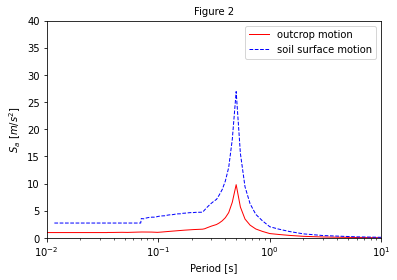

In [11]:
#Plots
fix, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
ax.plot(T_k       , Sa_outcrop , color='r', ls='-' , lw=1, label='outcrop motion')
ax.plot(T_k[0:num], Sa_soil    , color='b', ls='--', lw=1, label='soil surface motion')
ax.set_title('Figure 2', fontsize=10)
ax.set_xscale('log')
ax.set_ylabel('$S_a\ [m/s^2]$')
ax.set_xlabel('Period [s]')
ax.set_xlim(0.01,10)
ax.set_ylim(0,40)
ax.legend(loc='best')
plt.show()

### 6 Fourier Spectra

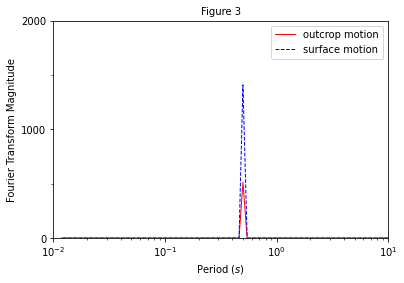

In [12]:
#Fourier Spectra
fig, ax=plt.subplots(nrows=1, ncols=1, figsize=(6,4))
ax.plot(T_k[0:num],abs(FFT_a_outcrop), label='outcrop motion', color='r',ls='-' , lw=1.0)
ax.plot(T_k[0:num],abs(FFT_a_soil)   , label='surface motion', color='b',ls='--', lw=1.0)
ax.set_title('Figure 3', fontsize=10)
ax.set_xscale('log')
ax.set_xlabel('Period $(s)$')
ax.set_ylabel('Fourier Transform Magnitude')
ax.set_xlim(1e-2,1e1)
ax.set_ylim(0,2000)
ax.yaxis.set_major_locator(mpl.ticker.FixedLocator([0, 1000, 2000]))
ax.yaxis.set_minor_locator(mpl.ticker.MaxNLocator(4))
ax.legend(loc='best')
plt.show()

### 7 Transfer Function (TF)

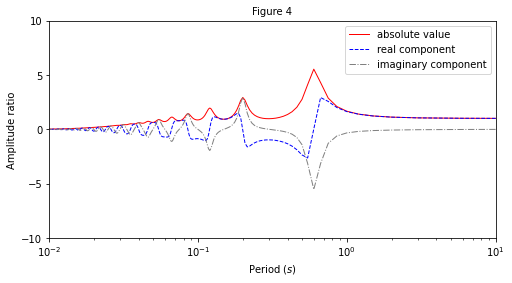

In [13]:
#Transfer function
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
ax.plot(T_k,abs(TF), label='absolute value'     , color='r'   , ls='-' , lw=1.0)  # absolute value
ax.plot(T_k,TF.real, label='real component'     , color='b'   , ls='--', lw=1.0)  # real component
ax.plot(T_k,TF.imag, label='imaginary component', color='gray', ls='-.', lw=1.0)  # imaginary component
ax.set_title('Figure 4', fontsize=10)
ax.set_xscale('log')
ax.set_xlabel('Period $(s)$')
ax.set_ylabel('Amplitude ratio')
ax.set_xlim(1e-2,1e1)
ax.set_ylim(-10,10)
ax.yaxis.set_major_locator(mpl.ticker.FixedLocator([-10, -5, 0, 5, 10]))
ax.legend(loc='best')
plt.show()

### 8 Verification

As a check, the amplification ratio at the same frequency as the input motion can be determined as: \\
$$ TF_{(T_k=0.5 sec)}$$

In [14]:
Tk    = 0.5                                                                                # period T=0.5
wk    = 2*math.pi/Tk                                                                       # frequency at T=0.5
ks_k  = wk/Vs_soil_complex                                                                 # complex wave number at T=0.5
TF_k  = 2/((1+alpha)*np.exp(complex(0,1)*ks_k*H)+(1-alpha)*np.exp(complex(0,-1)*ks_k*H))   # TF at T=0.5
amplification_ratio = abs(TF_k)
print(f'amplification_ratio = {amplification_ratio:.3f}')

amplification_ratio = 2.752


The peak accelerations at the soil surface and outcrop are:

In [15]:
peak_a_soil    = max(abs(a_soil))
peak_a_outcrop = max(abs(a_outcrop))
print(f'max_a_soil    = {peak_a_soil:.3f}')
print(f'max_a_outcrop = {peak_a_outcrop:.3f}')

max_a_soil    = 2.752
max_a_outcrop = 1.000


And the ratio of these is:

In [16]:
ratio = peak_a_soil / peak_a_outcrop
print(f'{ratio:.3f}')

2.752


Yes: the amplification ratio for the single harmonic frequency and the ratio of peak accelerations are the same, as they should.

### (a) Sensitivity to soil damping ratio

In [17]:
#Range of damping ratios
damping_soil    = np.linspace(0,0.20,21)
G_soil_complex  = density_soil * (Vs_soil**2) * (1+2j*damping_soil)                  # [Pa]
Vs_soil_complex = np.sqrt(G_soil_complex/density_soil)                               # [m/s]
alpha           = (density_soil*Vs_soil_complex) / (density_rock*Vs_rock_complex)    # complex impedance ratio
ks              = [ w_k/x for x in Vs_soil_complex ]                                 # complex wave number
ks              = np.array(ks)

In [18]:
#Transfer functions for all damping ratios considered in damping_soil
TF = []
i = 0
for x in ks :
  TF.append( 2/((1+alpha[i])*np.exp((1j)*x*H)+(1-alpha[i])*np.exp((-1j)*x*H)) )
  i = i+1
TF = np.array(TF)

In [19]:
#Fast Fourier Transform calculations
FFT_a_outcrop = fft(a_outcrop)                          # considering Np points
FFT_a_outcrop = FFT_a_outcrop[0:num]                    # considering Np/2 points (zero and positive-frequency values only)
FFT_a_soil    = [ x[0:num]*FFT_a_outcrop for x in TF ]  # considering Np/2 points (np.array of complex numbers)
FFT_a_soil    = np.array(FFT_a_soil)
a_soil        = ifft(FFT_a_soil)
peak_a_soil   = [ max(abs(x)) for x in a_soil]
peak_a_soil   = np.array(peak_a_soil)

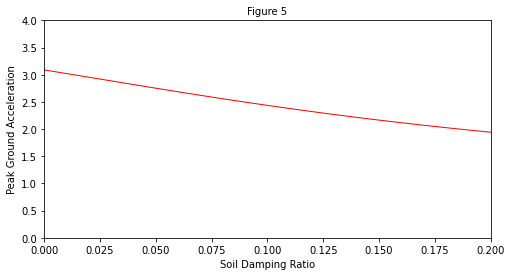

In [20]:
#Plots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
ax.plot(damping_soil, peak_a_soil, color='r', lw=1)
ax.set_title('Figure 5', fontsize=10)
ax.set_xlabel('Soil Damping Ratio')
ax.set_ylabel('Peak Ground Acceleration')
ax.set_xlim(0,0.2)
ax.set_ylim(0,4.0)
plt.show()

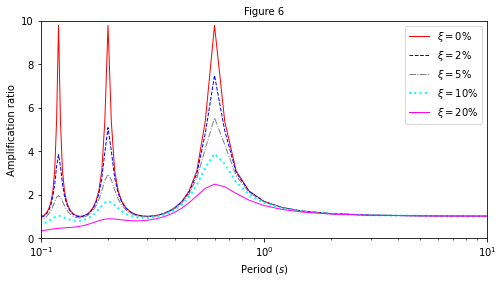

In [21]:
#Plots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
ax.plot(T_k,abs(TF[0]) , color='r'      , ls='-' , lw=1, label=r'$\xi=0\%$' ) #damping= 0%
ax.plot(T_k,abs(TF[2]) , color='b'      , ls='--', lw=1, label=r'$\xi=2\%$' ) #damping= 2%
ax.plot(T_k,abs(TF[5]) , color='gray'   , ls='-.', lw=1, label=r'$\xi=5\%$' ) #damping= 5%
ax.plot(T_k,abs(TF[10]), color='cyan'   , ls=':' , lw=2, label=r'$\xi=10\%$') #damping= 10%
ax.plot(T_k,abs(TF[20]), color='magenta', ls='-' , lw=1, label=r'$\xi=20\%$') #damping= 20%
ax.set_xscale('log')
ax.set_title('Figure 6', fontsize=10)
ax.set_xlabel('Period $(s)$')
ax.set_ylabel('Amplification ratio')
ax.set_xlim(0.1,10)
ax.set_ylim(0,10)
ax.legend(loc='best')
plt.show()

The above plot shows that the transfer function is most sensitive to damping ratio at the fundametal modes of the soil deposit. There are 3 modes that fall between periods of $0.1$ and $5$ $s$. The fundamental periods correspond to the maximum values for the transfer function, which occur when $exp(1j.k_s.H)=1\ or\ -1$. The first 3 modes, for **zero damping** in the soil layer (fundamental periods are only slightly affected by damping ratio), are given below: 

In [22]:
T_soil_1_0 = 4*H/abs(Vs_soil_complex[0])   #first  fundamental period considering zero damping (first mode)
T_soil_2_0 = 4*H/3/abs(Vs_soil_complex[0]) #second fundamental period considering zero damping (second mode)
T_soil_3_0 = 4*H/5/abs(Vs_soil_complex[0]) #third  fundamental period considering zero damping (third mode)
print(f'First period  = {T_soil_1_0:.3f} (damping = 0%)')
print(f'Second period = {T_soil_2_0:.3f} (damping = 0%)')
print(f'Third period  = {T_soil_3_0:.3f} (damping = 0%)')

First period  = 0.600 (damping = 0%)
Second period = 0.200 (damping = 0%)
Third period  = 0.120 (damping = 0%)


The effect of damping ratio on fundamental period can be illustrated by finding the first fundamental period for 10% damping as:

In [23]:
T_soil_1_10 = 4*H/abs(Vs_soil_complex[10]) 
print(f'First period  = {T_soil_1_10:.3f} (damping = 10%)')
print(f'only {(1-T_soil_1_10/T_soil_1_0)*100:.1f} % effect on period')

First period  = 0.594 (damping = 10%)
only 1.0 % effect on period


These periods are used to calculate the corresponding peak ground acceleration values

In [24]:
# Undamped modes of vibration of soil deposit
T_modes = np.array((4*H/abs(Vs_soil_complex[0]))/[1, 3, 5])
num_T = len(T_modes)

In [25]:
# Fundamental period for 10% of damping ratio
Tf_damped = 4*H/abs(Vs_soil_complex[10])

In [26]:
# Converting data to time domain
Tw        = T_modes            # period of the harmonic wave
dt        = Tw*Ncyc/Np         # increment of time (sampling interval)
t_k       = [k*x for x in dt]  # time domain: array of 'Np' points
t_k       = np.array(t_k)      # converting to Numpy array

# outcrop acceleration for each T_mode
a_outcrop = []
i = 0
for period in Tw :
  a_outcrop.append( amax_outcrop*np.sin(2*math.pi/period*t_k[i]) )
  i=i+1
a_outcrop = np.array(a_outcrop)

# Converting data to frequency domain
dw    = 2*math.pi/(Np*dt)   # increment of circular frequencies
w_k   = [k*x for x in dw]   # frequency domain: array of 'Np' points
w_k   = np.array(w_k)       # converting to Numpy array

# Complex soil stiffness for different soil damping values
damping_soil    = np.linspace(0,0.20,21)
n_damp          = len(damping_soil)
G_soil_complex  = density_soil * (Vs_soil**2) * (1+2j*damping_soil)                  # [Pa]
Vs_soil_complex = np.sqrt(G_soil_complex/density_soil)                               # [m/s]
alpha           = (density_soil*Vs_soil_complex) / (density_rock*Vs_rock_complex)    # complex impedance ratio

# Complex wave number
ks = np.zeros(shape=(num_T,n_damp,Np), dtype = 'complex_')  # 3x21x1024 (signal , dampings ratios, length of signal)
i=0
for x in w_k :  #w_k (3,1024)
  j=0
  for y in Vs_soil_complex : #Vs_soil_complex (21,)
    ks[i][j]= x/y
    j=j+1
  i=i+1  

#Transfer function (TF) (Kramer, 1996)
TF            = np.zeros(shape=(num_T,n_damp,Np) , dtype = 'complex_') # 3x21x1024
FFT_a_outcrop = np.zeros(shape=(num_T,Np)        , dtype = 'complex_') # 3x1024
FFT_a_soil    = np.zeros(shape=(num_T,n_damp,num), dtype = 'complex_') # 3x21x512
a_soil        = np.zeros(shape=(num_T,n_damp,num), dtype = 'complex_') # 3x21x512
peak_a_soil   = np.zeros(shape=(num_T,n_damp))                         # 3x21

i=0
for x in ks :
  j=0
  for y in x :
    TF[i][j]         = 2/((1+alpha[j])*np.exp(1j*y*H)+(1-alpha[j])*np.exp(-1j*y*H)) 
    FFT_a_outcrop[i] = fft(a_outcrop[i])
    FFT_a_soil[i][j] = TF[i][j][0:num] * FFT_a_outcrop[i][0:num]
    a_soil[i][j]     = ifft(FFT_a_soil[i][j])
    peak_a_soil[i][j]= max(abs(a_soil[i][j]))
    j=j+1
  i=i+1

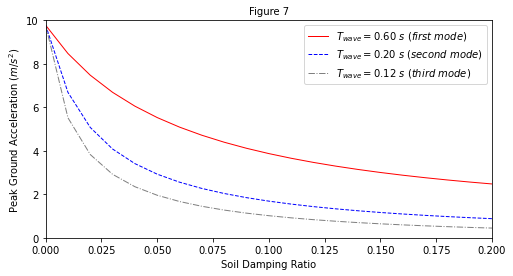

In [27]:
#Plots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
ax.plot(damping_soil,peak_a_soil[0] , color='r'      , ls='-' , lw=1, label=r'$T_{wave}=0.60\ s\ (first\ mode)$' ) #first  fundamental period
ax.plot(damping_soil,peak_a_soil[1] , color='b'      , ls='--', lw=1, label=r'$T_{wave}=0.20\ s\ (second\ mode)$' ) #second fundamental period
ax.plot(damping_soil,peak_a_soil[2] , color='gray'   , ls='-.', lw=1, label=r'$T_{wave}=0.12\ s\ (third\ mode)$' ) #third  fundamental period
ax.set_title('Figure 7', fontsize=10)
ax.set_xlabel('Soil Damping Ratio')
ax.set_ylabel('Peak Ground Acceleration ($m/s^2$)')
ax.set_xlim(0,0.2)
ax.set_ylim(0,10)
ax.legend(loc='best')
plt.show()

Notice that the Transfer Function at the 3rd mode ($T_{wave}=0.12s$) is more sensitive to damping ratio than the 2nd mode ($T_{wave}=0.20s$) , which is more sensitive to damping ratio than the 1st mode ($T_{wave}=0.60s$).
The Transfer Function is least sensitive to soil damping ratio at input periods midway between the fundamental periods of the soil layer, and at input periods ($T_{wave}$) much *higher* than the 1st fundamental period of the soil layer. To illustrate this, we will look at input periods of $0.15$, $0.30$ and $6.0$ $s$

In [28]:
# Loops for different harmonic waves (time domain) 
Tw        = np.array([6, 0.3, 0.15])  # periods of the harmonic wave
dt        = Tw*Ncyc/Np                # increment of time (sampling interval)
t_k       = [k*x for x in dt]         # time domain: array of 'Np' points
t_k       = np.array(t_k)             # converting to Numpy array

# outcrop acceleration for each T_mode
a_outcrop = []
i = 0
for period in Tw :
  a_outcrop.append( amax_outcrop*np.sin(2*math.pi/period*t_k[i]) )
  i=i+1
a_outcrop = np.array(a_outcrop)

# Converting data to frequency domain
dw    = 2*math.pi/(Np*dt)   # increment of circular frequencies
w_k   = [k*x for x in dw]   # frequency domain: array of 'Np' points
w_k   = np.array(w_k)       # converting to Numpy array

# Complex soil stiffness for different soil damping values
damping_soil    = np.linspace(0,0.20,21)
n_damp          = len(damping_soil)
G_soil_complex  = density_soil * (Vs_soil**2) * (1+2j*damping_soil)                  # [Pa]
Vs_soil_complex = np.sqrt(G_soil_complex/density_soil)                               # [m/s]
alpha           = (density_soil*Vs_soil_complex) / (density_rock*Vs_rock_complex)    # complex impedance ratio

# Complex wave number
ks = np.zeros(shape=(num_T,n_damp,Np), dtype = 'complex_')  # 3x21x1024 (signal , dampings ratios, length of signal)
i=0
for x in w_k :  #w_k (3,1024)
  j=0
  for y in Vs_soil_complex : #Vs_soil_complex (21,)
    ks[i][j]= x/y
    j=j+1
  i=i+1  

#Transfer function (TF) (Kramer, 1996)
TF            = np.zeros(shape=(num_T,n_damp,Np) , dtype = 'complex_') # 3x21x1024
FFT_a_outcrop = np.zeros(shape=(num_T,Np)        , dtype = 'complex_') # 3x1024
FFT_a_soil    = np.zeros(shape=(num_T,n_damp,num), dtype = 'complex_') # 3x21x512
a_soil        = np.zeros(shape=(num_T,n_damp,num), dtype = 'complex_') # 3x21x512
peak_a_soil   = np.zeros(shape=(num_T,n_damp))                         # 3x21

i=0
for x in ks :
  j=0
  for y in x :
    TF[i][j]         = 2/((1+alpha[j])*np.exp(1j*y*H)+(1-alpha[j])*np.exp(-1j*y*H)) 
    FFT_a_outcrop[i] = fft(a_outcrop[i])
    FFT_a_soil[i][j] = TF[i][j][0:num] * FFT_a_outcrop[i][0:num]
    a_soil[i][j]     = ifft(FFT_a_soil[i][j])
    peak_a_soil[i][j]= max(abs(a_soil[i][j]))
    j=j+1
  i=i+1

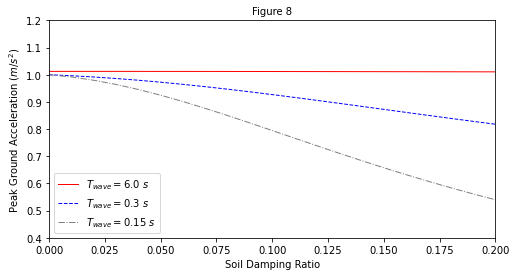

In [29]:
#Plots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
ax.plot(damping_soil,peak_a_soil[0] , color='r'      , ls='-' , lw=1, label=r'$T_{wave}=6.0\ s$' ) 
ax.plot(damping_soil,peak_a_soil[1] , color='b'      , ls='--', lw=1, label=r'$T_{wave}=0.3\ s$' ) 
ax.plot(damping_soil,peak_a_soil[2] , color='gray'   , ls='-.', lw=1, label=r'$T_{wave}=0.15\ s$' )
ax.set_title('Figure 8', fontsize=10)
ax.set_xlabel('Soil Damping Ratio')
ax.set_ylabel('Peak Ground Acceleration ($m/s^2$)')
ax.set_xlim(0,0.2)
ax.set_ylim(0.4,1.2)
ax.legend(loc='best')
plt.show()

Notice that the Transfer Function is independant of the soil damping ratio for the lowest input frequency (which is much lower than the 1st fundamental frequency of the soil layer), but does show dependence on soil damping ratio for input frequency midway between the 1st and 2nd and between the 2nd and 3rd modes. The effect of damping ratio increases as the input frequency increases.

In summary, the sensitivity of the peak soil surface acceleration to the soil damping ratio depends on **the period of the outcrop harmonic wave** (i.e., our input motion). If the input motion coincides with any of the fundamental periods of the soil layer, then the peak surface acceleration is strongly affected by the soil damping ratio (Figure 7). If the period of the input motion is much longer than the 1st fundamental period of the soil layer, then the peak soil surface acceleration is essentially unaffected by the soil damping ratio (Figure 8). 

### (b) Sensitivity to soil wave velocity

The sensitivity of the peak surface acceleration to the shear wave velocity of the soil layer can be anticipated based on the shape of the Transfer Function (plotted previously). For a shear wave velocity somewhere between 75 and 125 m/s, the **1st fundamental period of the soil layer** will be between: 

In [30]:
# Fundamental period of the soil layer
T0_1 = 4*H/75  
T0_2 = 4*H/100 
T0_3 = 4*H/125
print(f'Fundamental period for Vs 75 m/s  = {T0_1:.2f} ')
print(f'Fundamental period for Vs 100 m/s = {T0_2:.2f} ')
print(f'Fundamental period for Vs 125 m/s = {T0_3:.2f} ')

Fundamental period for Vs 75 m/s  = 0.80 
Fundamental period for Vs 100 m/s = 0.60 
Fundamental period for Vs 125 m/s = 0.48 


If the **period of the input motion** falls within the range of 0.48 to 0.80 s (fundamental periods of the soil layer), then the resonance of the soil layer is possible for some shear velocity value between 75 and 125 m/s. Under these conditions, the value of the Transfer Functon is most sensitive to small changes in either the input motion's period or the 1st fundamental period of the soil layer (i.e., through small changes in its shear wave velocity). 
The 2nd fundamental period of the soil later will be between:   

In [31]:
# 2nd period of the soil layer
T0_1 = 4*H/3/75  
T0_2 = 4*H/3/100 
T0_3 = 4*H/3/125
print(f'2nd period for Vs 75 m/s  = {T0_1:.3f} ')
print(f'2nd period for Vs 100 m/s = {T0_2:.2f} ')
print(f'2nd period for Vs 125 m/s = {T0_3:.2f} ')

2nd period for Vs 75 m/s  = 0.267 
2nd period for Vs 100 m/s = 0.20 
2nd period for Vs 125 m/s = 0.16 


If the **period of the input motion** was between 0.35 and 0.40 s, for example, then it would fall in between the 1st and 2nd fundamental periods of the soil layer regardless of its shear wave velocity (as long as it is between 75 and 125 m/s). In this situation, the peak soil surface acceleration would be relatively insensitive to the specified range of shear wave velocity values.

If the **period of the input motion** was greater than about 1.6 seconds (twice the possible value of the 1st fundamental period), then the peak soil surface acceleraton would be even less sensitive to the specified range of shear velocity values.